### 1. Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір).
### Вирішіть завдання щодо машинного перекладу.

In [21]:
import pandas as pd
import numpy as np

read_path = r"C:\Users\m.shovak\OneDrive\Рабочий стол\Studying\Data analysis\ukr.txt"
words = pd.read_csv(read_path,delimiter='\t',header=None).head(15000)
words.head(10)

,0,1,2
0,Go.,Йди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Вітаю!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Привіт.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Hi.,Привіт!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Run!,Біжіть!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
5,Run!,Тікайте!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
6,Run!,Біжи!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
7,Wow!,Оце так!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
8,Wow!,Клас!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
9,Wow!,Класно!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [22]:
words=words.drop(2, axis=1)
words.rename(columns={0: "ENG", 1: "UKR"},inplace=True)
words.head(10)

,ENG,UKR
0,Go.,Йди.
1,Hi.,Вітаю!
2,Hi.,Привіт.
3,Hi.,Привіт!
4,Run!,Біжіть!
5,Run!,Тікайте!
6,Run!,Біжи!
7,Wow!,Оце так!
8,Wow!,Клас!
9,Wow!,Класно!


#### Preprocessing of the text

In [23]:
from string import whitespace, ascii_letters

cyrillic =  u"абвгдежзиійклмнопрстуфхцчшщьєюяАБВГДЕЖЗИІЙКЛМНОПРСТУФХЦЧШЩЬЄЮЯ"
all_letters = cyrillic + whitespace + ascii_letters

def text_preprocessing(text):
    word = "".join([i for i in text if i in all_letters])
    word=word.lower()
    return word
words["ENG"]= words["ENG"].apply(text_preprocessing)
words["UKR"]=words["UKR"].apply(text_preprocessing)
words = words.drop_duplicates()

words[2000:2100]


,ENG,UKR
2087,it was tom,це був том
2088,it was bad,він був поганий
2089,it was bad,все пройшло погано
2090,it was big,він був великий
2091,it was big,вона була великою
...,...,...
2184,keep still,не рухайся
2185,keep still,не рухайтеся
2186,keep still,не ворушись
2187,keep still,не ворушіться


#### Tokenization

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(words['ENG'].values)
processed_eng, tokenizer_eng = tokenizer_eng.texts_to_sequences(words['ENG'].values), tokenizer_eng

tokenizer_ukr = Tokenizer()
tokenizer_ukr.fit_on_texts(words['UKR'].values)
processed_ukr, tokenizer_ukr = tokenizer_ukr.texts_to_sequences(words['UKR'].values), tokenizer_ukr

processed_eng = pad_sequences(processed_eng, maxlen=None, padding='post')
processed_ukr = pad_sequences(processed_ukr, maxlen=None, padding='post')

processed_ukr = processed_ukr.reshape(*processed_ukr.shape, 1)

english_sentence_length = processed_eng.shape[1]
ukr_sentence_length = processed_ukr.shape[1]
english_vocabulary = len(tokenizer_eng.word_index)
ukr_vocabulary = len(tokenizer_ukr.word_index)

print("The biggest English sentence:", english_sentence_length)
print("The biggest Ukrainian sentence", ukr_sentence_length)
print("English vocabulary size:", english_vocabulary)
print("Ukraine vocabulary size:", ukr_vocabulary)

The biggest English sentence: 5
The biggest Ukrainian sentence 9
English vocabulary size: 2669
Ukraine vocabulary size: 6453


#### Building of the model

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential

from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy


# learning_rate = 0.003

model = Sequential()

model.add(Embedding(english_vocabulary+1, 128, input_length=english_sentence_length, input_shape=processed_eng.shape[1:]))
# Encoder
model.add(Bidirectional(LSTM(128)))
model.add(RepeatVector(ukr_sentence_length))

# Decoder
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(512, activation='relu')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(ukr_vocabulary+1, activation='softmax')))
model.compile(loss=sparse_categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])

model.summary()

model.fit(processed_eng, processed_ukr,batch_size=64, epochs=200, validation_split=0.2)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 5, 128)            341760    
                                                                 
 bidirectional_12 (Bidirect  (None, 256)               263168    
 ional)                                                          
                                                                 
 repeat_vector_6 (RepeatVec  (None, 9, 256)            0         
 tor)                                                            
                                                                 
 bidirectional_13 (Bidirect  (None, 9, 256)            394240    
 ional)                                                          
                                                                 
 time_distributed_12 (TimeD  (None, 9, 512)            131584    
 istributed)                                          

In [41]:
ukr_id_to_word = {value: key for key, value in tokenizer_ukr.word_index.items()}
ukr_id_to_word[0] = '<EMPTY>'


# Assuming you have already defined tokenizer_eng
processed_eng = tokenizer_eng.texts_to_sequences(words['ENG'].values)
processed_eng = pad_sequences(processed_eng, maxlen=None, padding='post')

sentences = ['because I am happy', 'i can do it', 'i want to break free']
for sentence in sentences:
    sentence_seq = tokenizer_eng.texts_to_sequences([sentence])[0]
    sentence_seq = pad_sequences([sentence_seq], maxlen=processed_eng.shape[-1], padding='post')
    predictions = model.predict(sentence_seq)
    print(' '.join([ukr_id_to_word[np.argmax(prediction)] for prediction in predictions[0]]))


1/1 [==============================] - 0s 20ms/step
я щаслива <EMPTY> <EMPTY> <EMPTY> <EMPTY> <EMPTY> <EMPTY> <EMPTY>
1/1 [==============================] - 0s 28ms/step
я можу це зробити <EMPTY> <EMPTY> <EMPTY> <EMPTY> <EMPTY>
1/1 [==============================] - 0s 31ms/step
я я співаю <EMPTY> <EMPTY> <EMPTY> <EMPTY> <EMPTY> <EMPTY>


### 2.  Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

In [47]:
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering

# Sentence sentiment analysis
classifier = pipeline('sentiment-analysis')
sentence1= 'Doing makeup is something incredible'
print('Result 1:', classifier(sentence1))
sentence2= 'Drugs killed a lot of people'
print('Result 2:', classifier(sentence2))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Result 1: [{'label': 'POSITIVE', 'score': 0.9998788833618164}]
Result 2: [{'label': 'NEGATIVE', 'score': 0.9983311295509338}]


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_name = "robinhad/ukrainian-qa"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# The rest of your code...

qa_model = pipeline("question-answering", model=model.to("cpu"), tokenizer=tokenizer)
question = "Ти любиш портвейн?"
context = "Привіт. Я Славік і я люблю портвейн"
qa_model(question = question, context = context)

### 3. Завдання щодо стилізації зображень


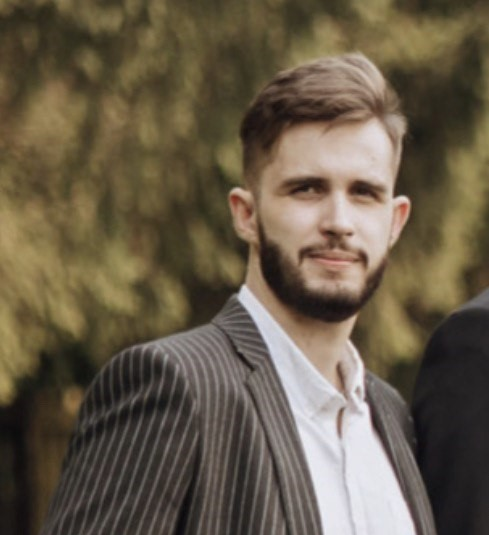

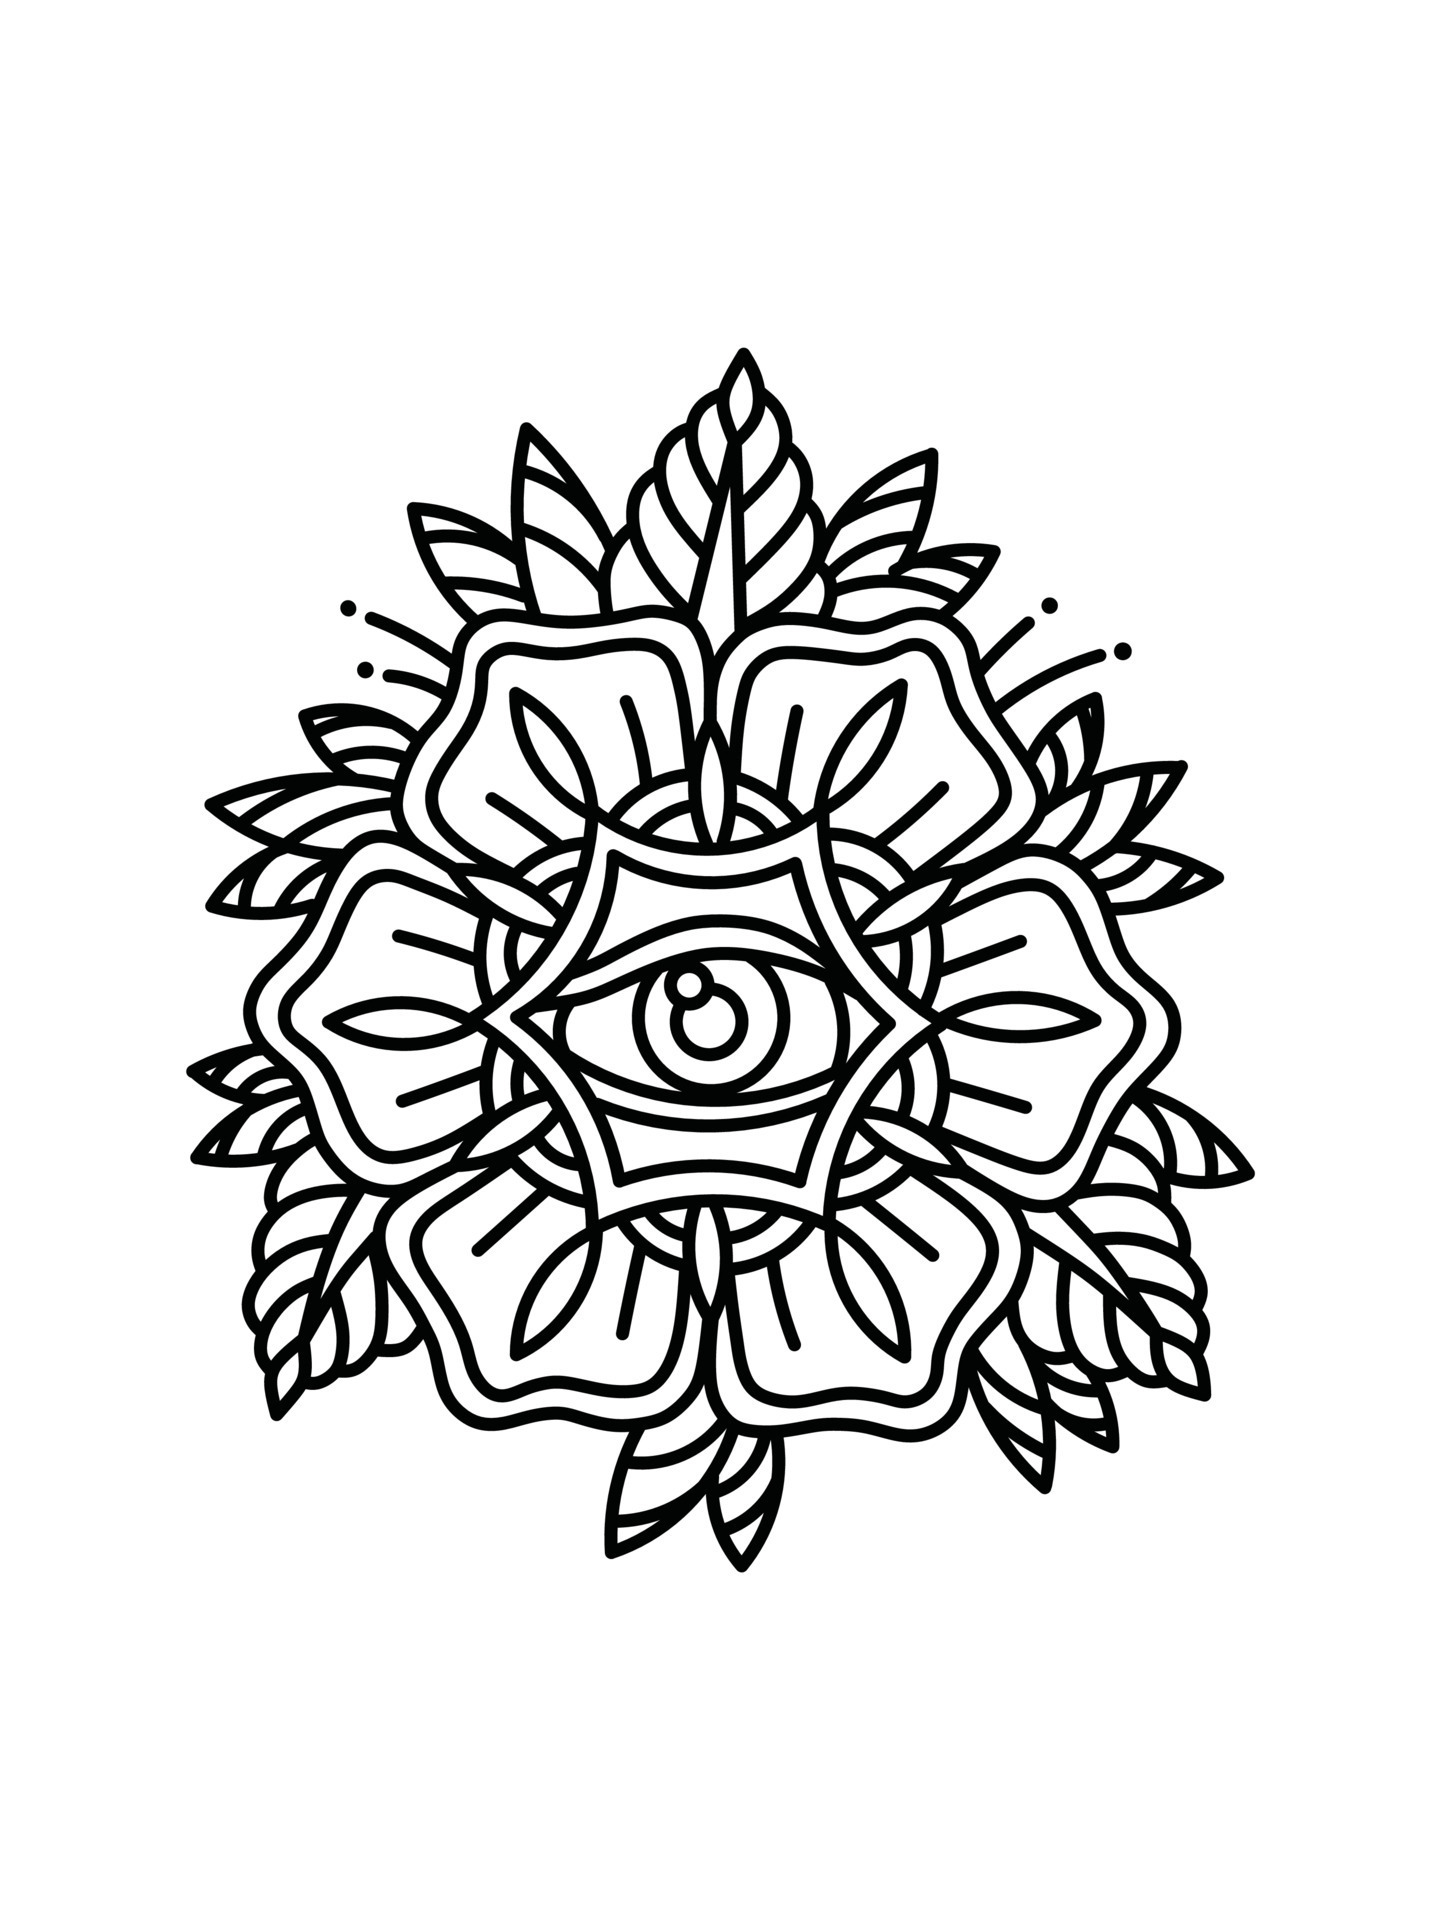

1
2
3
4
5
6
7
8
9
10
10 sec pause
Iteration 10: loss=122078.75
11
12
13
14
15
16
17
18
19
20
10 sec pause
Iteration 20: loss=79033.45
21
22
23
24
25
26
27
28
29
30
10 sec pause
Iteration 30: loss=57590.61
31
32
33
34
35
36
37
38
39
40
10 sec pause
Iteration 40: loss=42126.14
41
42
43
44
45
46
47
48
49
50
10 sec pause
Iteration 50: loss=36612.24


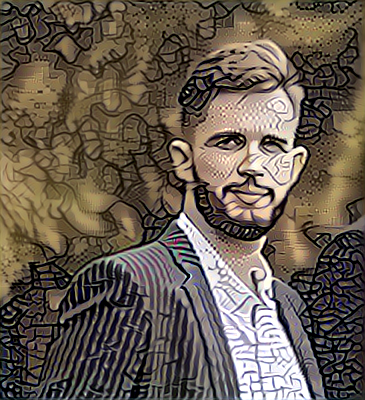

In [76]:
from matplotlib import pyplot as plt
import cv2
import os
import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19
from time import sleep
from IPython.display import Image, display
base_image_path = "test.jpg"
style_reference_image_path = "style.jpg"
result_prefix = "My_stylizied_photo"
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)
display(Image(base_image_path))
display(Image(style_reference_image_path))


def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))
model = vgg19.VGG19(weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 50
for i in range(1, iterations + 1):
    print(i)
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("10 sec pause")
        sleep(10)
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)
display(Image('My_stylizied_photo_at_iteration_50.png'))
